In [1]:
# %pip install transformer_lens # sae_lens
# %pip install matplotlib numpy scipy plotly pytest

# Setup

In [2]:
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from sae_lens.training.session_loader import LMSparseAutoencoderSessionloader
from huggingface_hub import hf_hub_download
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
# TOKENIZERS_PARALLELISM
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Get data

In [3]:
dataset = load_dataset("apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split='train', streaming=True)
shuffled_dataset = dataset.shuffle(seed=42, buffer_size=100)
dataloader = DataLoader(shuffled_dataset, batch_size=10)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

In [4]:
# Start by downloading them from huggingface
device = "cuda"
REPO_ID = "jbloom/GPT2-Small-SAEs"

def get_sae(layer):
    assert 0<=layer<12, "Layer must be between 0 and 11"
    FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

    # this is great because if you've already downloaded the SAE it won't download it twice!
    path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

    # We can then load the SAE, dataset and model using the session loader
    model, sparse_autoencoders, activation_store = (
        LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
    )
    assert len(list(sparse_autoencoders)) == 1, "There should only be one SAE in this file"
    return model, list(sparse_autoencoders)[0], activation_store

In [5]:
model, _, activation_store = get_sae(layer=8)
saes = []
for layer in range(12):
    model, sae, activation_store = get_sae(layer=layer)
    saes.append(sae)

n_features = sae.cfg.d_sae

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/mnt/ssd-interp/stefan/hackathon/hackathon_env/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-

# Collect SAE feature activations

In [6]:
def get_feature_activation_table(sae, dataloader=dataloader, batches=10):
    layer = sae.cfg.hook_point_layer
    big_feature_activation_table = []
    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
    for i, prompts in tqdm(enumerate(iter(dataloader)), desc=f"Getting activations for layer {layer}", total=batches):
        with torch.no_grad():
            prompts = torch.stack(prompts["input_ids"]).to(device)
            _, cache = model.run_with_cache(prompts, prepend_bos=True)
            _, feature_acts, _, _, _, _ = sae(
                cache[sae.cfg.hook_point]
            )
            del cache
            big_feature_activation_table.append(feature_acts[:, 1:, :].reshape(-1, n_features).cpu())
        if i==batches:
            break
    # for _ in tqdm(range(batches), desc=f"Getting activations for layer {layer}"):
    #     with torch.no_grad():
    #         batch_tokens = activation_store.get_batch_tokens()
    #         _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
    #         _, feature_acts, _, _, _, _ = sae(
    #             cache[sae.cfg.hook_point]
    #         )
    #         del cache
    #         big_feature_activation_table.append(feature_acts.view(-1, n_features).cpu())

    big_feature_activation_table = torch.cat(big_feature_activation_table, dim=0)
    return big_feature_activation_table

feature_activation_tables = []
for sae in saes:
    feature_activation_tables.append(get_feature_activation_table(sae))

Getting activations for layer 11: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


In [7]:
feature_activation_tables[0].shape #1M in 1min / 400k in 29s

torch.Size([101376, 24576])

Text(0, 0.5, 'Histogram over total of 24576 features\nCut at x<100 because we want to\nmake sure there are no low numbers')

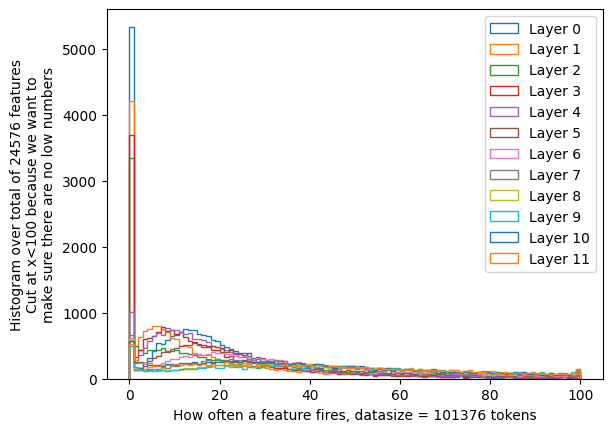

In [8]:
# Do we have a decent amount of activations for each feature?
for i, feature_activation_table in enumerate(feature_activation_tables):
    plt.hist((feature_activation_table != 0).sum(dim=0), range=(0, 100), bins=100, alpha=1, label=f"Layer {i}", histtype="step")
plt.legend()
plt.xlabel(f"How often a feature fires, datasize = {feature_activation_table.shape[0]} tokens")
plt.ylabel(f"Histogram over total of {n_features} features\nCut at x<100 because we want to\nmake sure there are no low numbers")
# Zero-acts: 350 for our dataset (1M tokens)
# Zero-acts: 10 for Josephs dataset (400k tokens)

# Compute the correlations

In [9]:
# correlations = []
# for layer in tqdm(range(11)):
#     feature_table_lower = feature_activation_tables[layer]
#     feature_table_upper = feature_activation_tables[layer+1]
#     # Calculate the correlation between the first 250 features
#     # of layer 1, and the 
#     correlation = torch.zeros(n_features, n_features)
#     cutoff = 250
#     for i in range(100):
#         for j in range(100):
#             slice_lower = slice(i*cutoff, (i+1)*cutoff)
#             slice_upper = slice(i*cutoff, (i+1)*cutoff)
#             a = feature_table_lower.T[slice_lower]
#             b = feature_table_upper.T[slice_upper]
#             corr = np.corrcoef(a,b)[:cutoff,cutoff:]
#             correlation[slice_lower, slice_upper] = corr
#     correlations.append(correlation)

In [10]:
import numpy as np
import torch
from tqdm import tqdm
from multiprocessing import Pool

# Worker function to compute correlation
def compute_correlation(args):
    i, j, feature_table_lower, feature_table_upper, cutoff = args
    slice_lower = slice(i * cutoff, (i + 1) * cutoff)
    slice_upper = slice(j * cutoff, (j + 1) * cutoff)
    a = feature_table_lower.T[slice_lower]
    b = feature_table_upper.T[slice_upper]
    corr = np.corrcoef(a, b)[:cutoff, cutoff:]
    return (i, j, corr)

def parallel_correlation(feature_table_lower, feature_table_upper, cutoff=256):
    n_features = feature_table_lower.shape[0]
    correlation = torch.zeros(n_features, n_features)

    # Prepare arguments for each task
    tasks = [(i, j, feature_table_lower, feature_table_upper, cutoff) for i in range(96) for j in range(96)]

    # Create a multiprocessing pool
    n_processes = 100
    with Pool(n_processes) as pool:
        # Map tasks to the pool and retrieve results asynchronously
        results = pool.map(compute_correlation, tasks)

        # Place results in the correct part of the correlation matrix
        for i, j, corr in tqdm(results):
            slice_lower = slice(i * cutoff, (i + 1) * cutoff)
            slice_upper = slice(j * cutoff, (j + 1) * cutoff)
            correlation[slice_lower, slice_upper] = torch.from_numpy(corr)

    return correlation

correlations = []
for layer in tqdm(range(11)):
    feature_table_lower = feature_activation_tables[layer]
    feature_table_upper = feature_activation_tables[layer + 1]
    correlation = parallel_correlation(feature_table_lower, feature_table_upper)
    correlations.append(correlation)


  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# Pandas df
import pandas as pd
df = {"layer_A": [], "layer_B": [], "feature_A": [], "feature_B": [], "correlation": []}
for layer in tqdm(range(11)):
    for i in range(len(correlations[layer])):
        for j in np.where(correlations[layer][i] > 0.1)[0]:
            df["layer_A"].append(layer)
            df["layer_B"].append(layer+1)
            df["feature_A"].append(i)
            df["feature_B"].append(j)
            df["correlation"].append(correlations[layer][i,j])
df = pd.DataFrame(df)
df.to_csv("filtered_correlations_100k_tokens.csv")

100%|██████████| 11/11 [00:00<00:00, 226.13it/s]


In [ ]:
assert False, "Old code below"

In [ ]:
edges = []
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        edges.append(((0, i), (1, j), correlation_matrix[i, j]))

# Create the graph

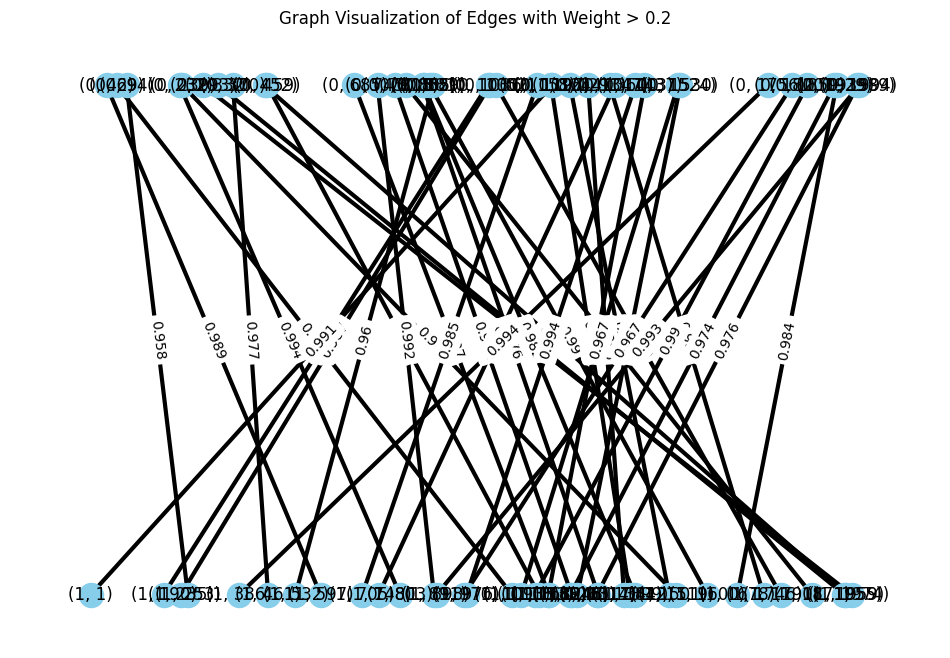

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_layered_graph(edges):
    # Create a graph object
    G = nx.Graph()
    
    # Add edges to the graph, nodes are automatically added
    for (u, v, w) in edges:
        if w > 0.95:
            G.add_edge(u, v, weight=w)

    # Define position layout based on the node labels (layer, feature)
    pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Invert y to have layer 1 on top if desired

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=3)
    edge_labels = {(u, v): round(w, 3) for u, v, w in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos)

    # Set plot options
    plt.title('Graph Visualization of Edges with Weight > 0.2')
    plt.axis('off')  # Hide axes
    plt.show()

plot_layered_graph(edges)
# 2, 129

In [ ]:
from pyvis.network import Network

def plot_layered_graph_pyvis(edges):
    # Create a network object with specific size
    net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white")
    
    # Add nodes and edges with selective visibility based on weight
    for (u, v, w) in edges:
        if w > 0.2:
            net.add_node(u[1], label=f"{u[0]}-{u[1]}", title=f"Layer: {u[0]}, Feature: {u[1]}")
            net.add_node(v[1], label=f"{v[0]}-{v[1]}", title=f"Layer: {v[0]}, Feature: {v[1]}")
            net.add_edge(u[1], v[1], value=w, title=f"Weight: {w:.3f}")

    # Generate positions based on layer and feature indices
    for node in net.nodes:
        node_id = node['id']
        node['x'] = node_id * 100  # space out by feature index
        node['y'] = node_id * 100

    # Set physics for better stability in layout
    net.set_options("""
    {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -30000,
          "centralGravity": 0.3,
          "springLength": 95,
          "springConstant": 0.04,
          "damping": 0.09,
          "avoidOverlap": 0.2
        },
        "maxVelocity": 50,
        "minVelocity": 0.1,
        "timestep": 0.5
      }
    }
    """)

    # Display the network
    net.show("graph.html")

plot_layered_graph_pyvis(edges)

graph.html
